<a href="https://colab.research.google.com/github/AlainSG/NotebookRepository/blob/master/RedNeuronalDesdeCero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

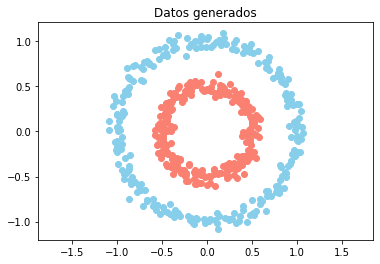

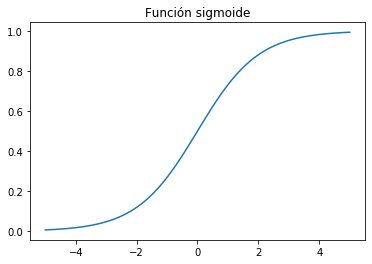

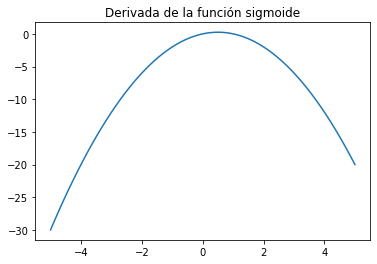

In [75]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
# make_circle permite generar un dataset en forma de círculo
from sklearn.datasets import make_circles

"""
 Crear el dataset. 
 Factor indica la distancia entre los círculos. 
 Noise hace que en vez de aparcer lineas continuas en los círculos
 estos sean puntos.
 X son los círculos
 Y es a qué círculo pertenece cada punto
 """
n = 500
p = 2
X, Y = make_circles(n_samples=n, factor=0.5, noise=0.05)
Y = Y[:, np.newaxis]
plt.scatter(X[Y[:, 0] == 0, 0], X[Y[:, 0] == 0, 1], c='skyblue')
plt.scatter(X[Y[:, 0] == 1, 0], X[Y[:, 0] == 1, 1], c='salmon')
plt.axis('equal')
plt.title('Datos generados')
plt.show()


'''
Vamos a crear una red neuronal desde cero que clasifique los datos generados
'''

class neural_layer():

  '''
    Los parámetros de entrada son:
    n_conn: número de entradas que recibe la capa (desde la anterior)
    n_neur: número de neuronas que tiene
    f_act: función de activación
    b: parámetro de bias, tantos como neuronas
    W: vector de pesos de las neuronas. Por cada neurona hay tantos pesos como
    neuronas le llegan de la capa anterior
  '''
  def __init__(self, n_conn, n_neur, act_f):
    self.act_f = act_f 
    '''
      Vamos a inicializar el bias. Es un vecor con longitud igual al número
      de neuronas. Es decir un bias para pada neurona.
      np.random() devuelve valores entre [0-1] y los queremos ente [-1 1] por 
      eso añadimos el *2 -1
      Los pesos W se representan en una matriz [n_conn x n_neur]
    '''
    self.b = np.random.rand(1, n_neur) * 2 -1
    self.W = np.random.rand(n_conn, n_neur) * 2 -1


'''
  Funciones de activación
  sigm: función sigmoide.
  A la hora de hacer el backpropagation vamos a tener que calcular la derivada
  de la función de activación. Para ahorrar tiempo la creo dentro del lambda.
  Este lambda tiene dos funciones separadas por comas, la propia función sigmoide
  y su derivada
'''

sigm = (lambda x: 1/(1 + np.e ** (-x)), 
        lambda x: x * (1- x))

_x = np.linspace(-5, 5, 100)

plt.plot(_x, sigm[0](_x))
plt.title('Función sigmoide')
plt.show()

plt.plot(_x, sigm[1](_x))
plt.title('Derivada de la función sigmoide')
plt.show()



In [0]:
'''
Vamos a empezar a crear nuestra red neuronal
lo: capa de entrada
l1: capa siguiente...
topology indica el número de neuronas de cada capa
Esta red podría ampliarse añadiendo muchas más opciones como diferentes tipos de
activación por cada papa etc.
'''

def create_nn(topology, act_f):
  nn = []
  '''
    Como recorremos el vector y hacemos un +1 de la posición, para no superar
    el límite del vector ponemos el [:-1] para que lo recorra sólo asta la ante
    última posición
  '''
  for l, layer in enumerate(topology[:-1]):
    '''
      El primer parámetro l indica el número de entradas que le llegan a la capa
      y el l+1 son el número de neuronas.
    '''
    nn.append(neural_layer(topology[l], topology[l+1], act_f))
  return nn

In [0]:
'''
  Vamos a definir la lógica de la red neuronal.
  Hasta ahora sólo hemos definido su arquitectura.
'''

topology = [p, 4, 8, 1]
nerual_net = create_nn(topology, sigm)

'''
  Al hacer backpropagation hace falta calcular la derivada de la función loss
  Para ahorrar tiempo la incluimos, como hemos hecho antes en las funciones
  lambda.
  Yp: es el valor predicho
  Yr: es el valor real
'''

l2_cost = (lambda Yp, Yr: np.mean((Yp - Yr) ** 2),
           lambda Yp, Yr: (Yp - Yr))



In [0]:
'''
  Ahora vamos a definir la función de entrenamiento de la red. Los parámetros
  son:
  neural_net
  X: datos de entrenamiento
  Y: target de los datos de entrenamiento
  l2_cost: es la función de loss
  lr: es el learning rate

  El entrenamiento de la red tiene 3 pasos fundamentales:
    1- Paso hacia adelante
    2- Backpropagation: cálculo de loss: l2_cost hemos decidido que sea MSE
    3- Gradient Descent
'''

def train(neural_net, X, Y, l2_cost, lr=0.5, train=True):
  '''
    Paso hacia adelante. Pasar la entrada X a lo largo de las capas.
    Para ello hay que multiplicar el vector X por los pesos, de forma matricial,
    por eso usamos el @ y después sumarle el bias correspondiente

    Una vez hecho esto calculamos la activación.
    out sirve para ir guardando los cálculos a lo largo de las capas. 
    out = [None, X] es para la primera iteración del bucle. Para la primera capa
    la entrada será X.

    La variable train la añadimos para dar la opción de entrenar, o simplemente
    realizar una predicción que no necesita de cálculo de loss ni backpropagation
  '''
  out = [(None, X)]
  for l, layer in enumerate(neural_net):
    '''
      out[-1][1] sirve para recoger los valores z y a de la capa anterior. En
      este caso sólo nos interesa coger z, por eso cogemos la posición 1.
    '''
    z = out[-1][1] @ neural_net[l].W + neural_net[l].b
    a = neural_net[l].act_f[0](z)
    out.append((z, a))

  if train:

    '''
      Backpropagation.
      Calcular las derivadas parciales de los pesos W y bias b.
      Lo que se hace es ir propagando el error de la red hacia atrás. Esto
      lo hacemos sobre la variable delta.
      Las formulas se pueden buscar en internet.

    '''
    deltas = []
    '''
      Recorremos las capas de atrás hacia adeante.
      La delta de la última capa se calcula con otrá fórmula que el resto
      de capas
    '''
    for l in reversed(range(0, len(neural_net))):
      '''
        Cogemos los valores de la última capa que se han generado en el 
        forward.
      '''
      z = out[l+1][0]
      a = out[l+1][1]

      if(l == len(neural_net) -1):
        '''
          Calculamos el delta de la última capa y lo añadimos con insert 
          porque estamos yendo de atrás adelante. Si ponemos append lo añade 
          al final.
          Recordar que l2_cost[1] era la derivada de la función de coste que
          la habíamos definido con las lambda. Lo mismo ocurre con la función
          de activación.
        '''
        deltas.insert(0, l2_cost[1](a, Y) * neural_net[1].act_f[1](a))
      else:
        # Calculamos el delta del resto de capas
        deltas.insert(0, deltas[0] @ _W.T * neural_net[1].act_f[1](a))

      _W = neural_net[l].W
      '''
        Gradient descent: hacemos uso de las deltas para optimizar los 
        parámetros de la red.
        En primer lugar actualizamos los bias 
        En segundo lugar actualizamos los W
      '''
      neural_net[l].b = neural_net[l].b - np.mean(deltas[0], axis=0, 
                                                  keepdims=True) * lr
      neural_net[l].W = neural_net[l].W - out[l][1].T @ deltas[0] * lr
    # se devuelve el valor del output de la última capa
  return out[-1][1]

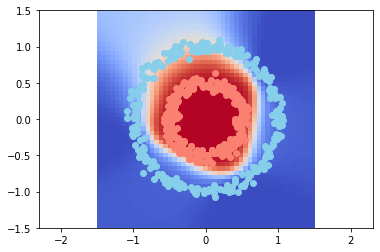

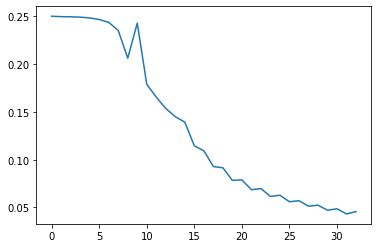

KeyboardInterrupt: ignored

In [79]:
'''
  PRUEBA DE TODO LO ANTERIOR
'''
import time
from IPython.display import clear_output

neural_n = create_nn(topology, sigm)

loss = []

for i in range(2500):
    
  # Entrenemos a la red!
  pY = train(neural_n, X, Y, l2_cost, lr=0.05)
  
  if i % 25 == 0:
    
    print(pY)
  
    loss.append(l2_cost[0](pY, Y))
  
    res = 50

    _x0 = np.linspace(-1.5, 1.5, res)
    _x1 = np.linspace(-1.5, 1.5, res)

    _Y = np.zeros((res, res))

    for i0, x0 in enumerate(_x0):
      for i1, x1 in enumerate(_x1):
        _Y[i0, i1] = train(neural_n, np.array([[x0, x1]]), Y, l2_cost, train=False)[0][0]    

    plt.pcolormesh(_x0, _x1, _Y, cmap="coolwarm")
    plt.axis("equal")

    plt.scatter(X[Y[:,0] == 0, 0], X[Y[:,0] == 0, 1], c="skyblue")
    plt.scatter(X[Y[:,0] == 1, 0], X[Y[:,0] == 1, 1], c="salmon")

    clear_output(wait=True)
    plt.show()
    plt.plot(range(len(loss)), loss)
    plt.show()
    time.sleep(0.5)  


